In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses, metrics, optimizers, callbacks
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from imblearn.metrics import classification_report_imbalanced

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt
import requests

In [3]:
df = pd.read_csv('./DryBeanDataset/Dry_Bean_Dataset.csv').sample(frac=1).reset_index(drop=True)

In [4]:
df.head(10)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,84334,1123.665,370.966423,290.369127,1.277568,0.622353,85612,327.684885,0.778276,0.985072,0.839342,0.883328,0.004399,0.001652,0.780268,0.996845,BARBUNYA
1,64839,953.714,370.229724,223.892876,1.653602,0.796423,65397,287.324866,0.707764,0.991467,0.895798,0.776072,0.005710,0.001278,0.602288,0.995944,CALI
2,48892,825.048,312.503481,199.748839,1.564482,0.769050,49353,249.501960,0.820556,0.990659,0.902587,0.798397,0.006392,0.001602,0.637438,0.997261,SIRA
3,29494,635.349,236.393694,159.218566,1.484712,0.739159,29830,193.785776,0.771428,0.988736,0.918161,0.819759,0.008015,0.002233,0.672004,0.997733,DERMASON
4,129409,1348.888,484.364424,341.172659,1.419705,0.709831,130688,405.917056,0.799334,0.990213,0.893763,0.838041,0.003743,0.001139,0.702312,0.997076,BOMBAY
5,51071,833.064,300.387070,216.692076,1.386239,0.692543,51633,255.001209,0.774754,0.989115,0.924757,0.848909,0.005882,0.001884,0.720646,0.998988,SEKER
6,72923,1083.134,406.963153,229.197676,1.775599,0.826327,74095,304.710432,0.689932,0.984182,0.781106,0.748742,0.005581,0.001082,0.560615,0.995427,BARBUNYA
7,51408,866.227,300.842462,218.056725,1.379652,0.688938,52127,255.841159,0.743610,0.986207,0.860948,0.850416,0.005852,0.001888,0.723207,0.997774,SEKER
8,25537,597.771,229.832389,141.785143,1.620991,0.787036,25884,180.318380,0.722200,0.986594,0.898070,0.784565,0.009000,0.002103,0.615542,0.997787,DERMASON
9,42506,748.990,259.418196,209.126437,1.240485,0.591730,42916,232.637744,0.799947,0.990446,0.952156,0.896767,0.006103,0.002435,0.804192,0.997587,SEKER


In [5]:
net = tf.keras.Sequential(
    [
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(7)
    ]
)

In [6]:
X = df.drop(columns=["Class"]).values
y = df.Class.astype("category").cat.codes.values

In [7]:
# X, y = SMOTE().fit_resample(X, y)

In [8]:
# scaling the the data for training!
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)

X_train = scaler.fit_transform(X_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25
)

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

In [12]:
net.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        metrics.SparseCategoricalAccuracy()
    ]
)

In [13]:
history = net.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=10, 
    callbacks=[
        callbacks.ModelCheckpoint('models/2', save_best_only=True, verbose=3),
    ]
)

Epoch 1/10
237/240 [============================>.] - ETA: 0s - loss: 0.5101 - sparse_categorical_accuracy: 0.8444
Epoch 00001: val_loss improved from inf to 0.24518, saving model to models\2
INFO:tensorflow:Assets written to: models\2\assets
240/240 [==============================] - 3s 8ms/step - loss: 0.5075 - sparse_categorical_accuracy: 0.8450 - val_loss: 0.2452 - val_sparse_categorical_accuracy: 0.9177
Epoch 2/10
227/240 [===========================>..] - ETA: 0s - loss: 0.2254 - sparse_categorical_accuracy: 0.9189
Epoch 00002: val_loss improved from 0.24518 to 0.21549, saving model to models\2
INFO:tensorflow:Assets written to: models\2\assets
240/240 [==============================] - 2s 7ms/step - loss: 0.2245 - sparse_categorical_accuracy: 0.9190 - val_loss: 0.2155 - val_sparse_categorical_accuracy: 0.9189
Epoch 3/10
239/240 [============================>.] - ETA: 0s - loss: 0.2053 - sparse_categorical_accuracy: 0.9252
Epoch 00003: val_loss improved from 0.21549 to 0.20733, s

In [14]:
# Transforming the test set

X_test = scaler.transform(X_test)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

In [15]:
net.evaluate(test_ds)

213/213 [==============================] - 1s 3ms/step - loss: 0.2110 - sparse_categorical_accuracy: 0.9242


[0.211009219288826, 0.9241845607757568]

In [16]:
preds = net(X_test)
preds = tf.argmax(preds, axis=1)

In [20]:
cf = confusion_matrix(y_test, preds)

classes = df.Class.astype("category").cat.categories.tolist()
print(classification_report_imbalanced(y_test, preds, target_names=classes))

                   pre       rec       spe        f1       geo       iba       sup

   BARBUNYA       0.92      0.92      0.99      0.92      0.95      0.90       327
     BOMBAY       1.00      0.97      1.00      0.98      0.98      0.96       154
       CALI       0.91      0.95      0.99      0.93      0.97      0.93       390
   DERMASON       0.92      0.92      0.97      0.92      0.94      0.89       872
      HOROZ       0.96      0.95      0.99      0.95      0.97      0.94       504
      SEKER       0.94      0.95      0.99      0.95      0.97      0.94       523
       SIRA       0.88      0.87      0.97      0.87      0.92      0.84       633

avg / total       0.92      0.92      0.98      0.92      0.95      0.90      3403



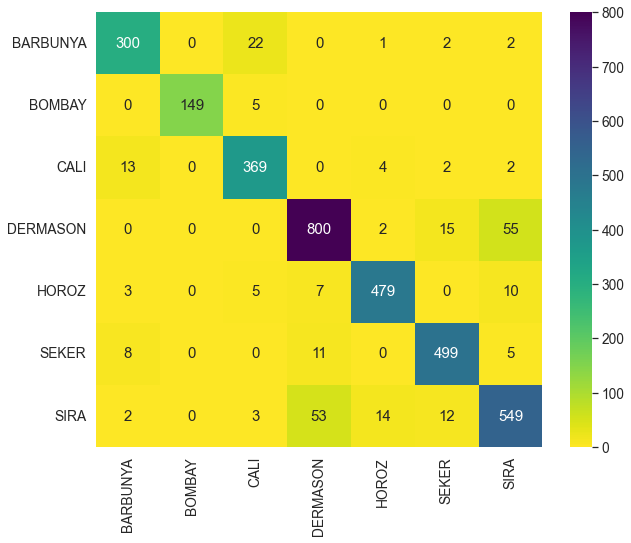

In [18]:
classes = df.Class.astype("category").cat.categories.tolist()
sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)
_ = sns.heatmap(cf, annot=True, xticklabels=classes, yticklabels=classes, fmt="d", cmap="viridis_r")

## Testing on one example

In [23]:
sample = X_test[100]
sample, y_test[100]

(array([7.05730000e+04, 1.04901600e+03, 3.94676397e+02, 2.28370126e+02,
        1.72823129e+00, 8.15592825e-01, 7.17450000e+04, 2.99760462e+02,
        6.72636294e-01, 9.83664367e-01, 8.05905684e-01, 7.59509471e-01,
        5.59245600e-03, 1.14792900e-03, 5.76854637e-01, 9.96938232e-01]),
 0)

In [24]:
X_test_scaled = scaler.transform(X_test)

In [18]:
def predict(feats):
    idx2class = {
        0: 'BARBUNYA',
        1: 'BOMBAY',
        2: 'CALI',
        3: 'DERMASON',
        4: 'HOROZ',
        5: 'SEKER',
        6: 'SIRA'
    }
    
    payload = {
        "instances": [
            feats.tolist()
        ]
    }

    res = requests.post(
        url='http://localhost:8605/v1/models/dry_bean_model:predict', 
        json=payload
    )

    preds = res.json()
    preds = preds['predictions']
    idx = tf.argmax(preds, axis=1)
    
    print(f"The predicted class is: {idx2class[idx.numpy()[0]]}")

In [22]:
predict(X_test_scaled[101])

The predicted class is: DERMASON
